***Fundamentals of Solar Cells and Photovoltaic Systems Engineering***

**Solutions Manual - Chapter 4**

***Problem 4.4***


***The lower the $V_{OC}$ the more the FF is affected by the $R_S$. Demonstrate this by comparing how the FF varies when increasing the $R_S$ from 0 to 0.01 Ω in the silicon solar cell from Problem 4.2 and in another cell with the same characteristics but a reverse saturation current of $I_0$ = $10^{-12}$ A. Explain this effect by qualitatively analyzing the changes in the I-V curve shape with these parameters.***



First, we import the Python modules used, define one constant to set the I-V curve data size, and define the Boltzman constant.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

DATA_SIZE = 500
kB = 8.617333e-5  # eV·K-1

We define the variables for the I-V curve data

In [2]:
# These are values in the usual range for a typical 16.6 x 16.6 cm2 Si solar cell
IL = 9.0 # A
I0_1 = 1e-10 # A
I0_2 = 1e-12
n = 1
Rs_a=0
Rs_b=0.01
Rp=1e6

temperature = 25  #ºC
cell_area = 15*15 # cm2

Now we define a function to calculate the I-V curve of the solar cell.
Note that we use a number of data points defined as the constant DATA_SIZE. The larger this number, the higher the precision, but also the longer computation time. Since the calculations are not very complex, you can use high numbers with almost instantaenous calculations in modern desktop computers or laptops.

In [3]:
def model_IV(IL, I0, n, Rs, Rp, temperature):
    # Thermal voltage
    kBT = kB*(temperature + 273.15)
    
    #I-V curve stored in a 2-column array: first column for voltages, second column for currents
    IVcurve = np.zeros((DATA_SIZE,2))
    
    # First, we calculate the I-V curve voltage range: from -0.1 V to Voc + 0.01 V
    # We want to have the I-V curve crossing the current and voltage axes to see the Isc and Voc
    # Voc without Rs/Rp.
    Voc0 = n*kBT*math.log(IL/I0)
    
    #Create the voltage list
    #Voltage range used: -0.1 to Voc+0.01
    IVcurve[:,0]= np.linspace(-0.1, Voc0+0.01, DATA_SIZE)
    
    #I-V curve without Rs effect
    IVcurve[:,1] = IL - I0*(np.exp(IVcurve[:,0]/(n*kBT))-1) - IVcurve[:,0]/Rp
    
    #Shift voltages to include Rs effect
    IVcurve[:,0] = IVcurve[:,0] - Rs*IVcurve[:,1]
    
    return IVcurve

We define another function to get the Pmax. Note that this function does not assume that the I-V curve is in the first quadrant. 

Another two functions are used to calculate the Isc and Voc and detect the quadrant. Then, the function calculating Pmax moves the I-V curve to this quadrant, if it is not there yet. 

In [4]:
# Obtains Isc by linear interpolation around V=0
def get_Isc(IVdata):
    """Returns the Isc of the input raw I-V curve"""

   # Sort data (interpolation function requires sorted data)
    IV_sorted = IVdata.copy()
    IV_sorted=IVdata[IVdata[:,0].argsort()] #Sort by voltages  
    
    Isc = np.interp(0,IV_sorted[:,0],IV_sorted[:,1])
    
    return Isc

# Obtains Voc by linear interpolation around I=0
def get_Voc(IVdata):
    """Returns the Voc of the input raw I-V curve"""

   # Sort data (interpolation function requires sorted data)
    IV_sorted = IVdata.copy()
    IV_sorted=IVdata[IVdata[:,1].argsort()]   #Sort by currents
    
    Voc = np.interp(0, IV_sorted[:,1],IV_sorted[:,0])
    
    return Voc

# Obtains the Pmax, and also the Vm and Im
def get_Pmax(IVdata):
  
   # Sort data and move to 1st quadrant
    IV_sorted = IVdata.copy()
 
    Isc = get_Isc(IV_sorted)
    if Isc<0:
        Isc*=-1
        IV_sorted[:,1]*=-1
    
    Voc = get_Voc(IV_sorted)
    if Voc<0:
        Voc*=-1
        IV_sorted[:,0]*=-1       
 
    IV_sorted=IV_sorted[IV_sorted[:,0].argsort()]   
   
 
    PV = IV_sorted.copy()
    PV[:,1] = IV_sorted[:,0]*IV_sorted[:,1]
    
    Pm = np.amax(PV[:,1])
    maxPosition = np.argmax(PV[:,1])
    Vm = PV[maxPosition,0]
    Im = IV_sorted[maxPosition,1]

    return Pm, Vm, Im

We can now plot the I-V curve and calculate the most representative parameters

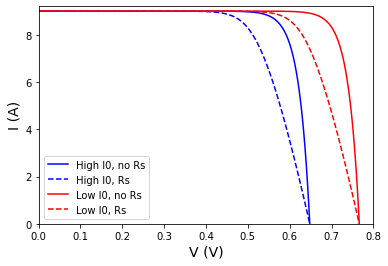

Solar cell with J0=1e-10A, FF changes 0.84 to 0.71
Solar cell with J0=1e-12A, FF changes 0.86 to 0.75


In [6]:

IV_curve_1a = model_IV(IL, I0_1, n, Rs_a, Rp, temperature)
Pm, Vm, Im = get_Pmax(IV_curve_1a)
Eff_1a = Pm/(cell_area/10000*1000)
Voc_1a = get_Voc(IV_curve_1a)
Isc_1a = get_Isc(IV_curve_1a)
FF_1a= Pm/(Isc_1a*Voc_1a)

IV_curve_1b = model_IV(IL, I0_1, n, Rs_b, Rp, temperature)
Pm, Vm, Im = get_Pmax(IV_curve_1b)
Eff_1b = Pm/(cell_area/10000*1000)
Voc_1b = get_Voc(IV_curve_1b)
Isc_1b = get_Isc(IV_curve_1b)
FF_1b= Pm/(Isc_1b*Voc_1b)


IV_curve_2a = model_IV(IL, I0_2, n, Rs_a, Rp, temperature)
Pm, Vm, Im = get_Pmax(IV_curve_2a)
Eff_2a = Pm/(cell_area/10000*1000)
Voc_2a = get_Voc(IV_curve_2a)
Isc_2a = get_Isc(IV_curve_2a)
FF_2a= Pm/(Isc_2a*Voc_2a)

IV_curve_2b = model_IV(IL, I0_2, n, Rs_b, Rp, temperature)
Pm, Vm, Im = get_Pmax(IV_curve_2b)
Eff_2b = Pm/(cell_area/10000*1000)
Voc_2b = get_Voc(IV_curve_2b)
Isc_2b = get_Isc(IV_curve_2b)
FF_2b= Pm/(Isc_2b*Voc_2b)

# Plot the data
plt.plot(IV_curve_1a[:,0], IV_curve_1a[:,1], color='b', label="High I0, no Rs")
plt.plot(IV_curve_1b[:,0], IV_curve_1b[:,1], color='b', linestyle='dashed', label="High I0, Rs")
plt.plot(IV_curve_2a[:,0], IV_curve_2a[:,1], color='r', label="Low I0, no Rs")
plt.plot(IV_curve_2b[:,0], IV_curve_2b[:,1], color='r', linestyle='dashed', label="Low I0, Rs")


plt.xlabel('V (V)', size=14)
plt.ylabel('I (A)', size=14)
plt.xlim(0,0.8)
plt.ylim(0,9.2)

plt.legend(loc='lower left')
plt.show()

# Report the values
sResult = ("Solar cell with " +
          "J0=" + str(I0_1) + "A, " +
          "FF changes " + str(round(FF_1a,2)) + " to " + str(round(FF_1b,2)))
print(sResult)
           
sResult = ("Solar cell with " +
          "J0=" + str(I0_2) + "A, " +
          "FF changes " + str(round(FF_2a,2)) + " to " + str(round(FF_2b,2)) )
print(sResult)

The lower decrease in FF for higher $I_0$ is due to the fact that the $R_S$ causes the same bending of the I-V curve around the maximum power point regardless of the $V_{OC}$. In fact, the effect of $R_S$ only depends on the current. For a higher $V_{OC}$ this area represents a lower fraction of the total area under the I-V curve, hence anything that happens in this area will influence the overall FF to a lower extent. 